# Assignment 3: Agentic RAG System with Azure OpenAI, Pinecone & LangGraph

#### Author: Shubhda Datta
#### Python: 3.12

In [104]:
# !python -m pip install langchain-community langchainhub langchain-chroma langchain langchain-experimental --quiet
# !python -m pip install langchain_openai azure-ai-inference azure-core azure-identity langgraph --quiet
# !python -m pip install pypdf faiss-cpu --quiet
# !python -m pip install pinecone --quiet
# !python -m pip install --upgrade packaging
# !python -m pip install mlflow --quiet


In [105]:
#!python -m pip install --upgrade pip --quiet

### Step 1: Library imports and log setup

In [106]:
import os,json, time
import mlflow
import pandas as pd
import logging
from typing import Dict, Any, List, Tuple, Optional
import pinecone
from tqdm import tqdm
import textwrap

from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.vectorstores import Chroma

from azure.ai.inference import EmbeddingsClient, ChatCompletionsClient
from azure.core.credentials import AzureKeyCredential
from langgraph.graph import StateGraph, END
from pydantic import BaseModel


### Logging Setup


In [107]:

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)


### Step 2: Initialize Embedding and llm Model

In [108]:

embedding_model_name = "text-embedding-3-small"
llm_model_name = "gpt4o"

In [109]:

def init_openai_clients() -> Tuple[AzureOpenAIEmbeddings, AzureChatOpenAI]:
    """Initialize Azure OpenAI embeddings and chat models."""
    api_key = os.getenv("AZURE_OPENAI_API_KEY")
    endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    version = os.getenv("AZURE_OPENAI_API_VERSION")

    if not api_key or not endpoint:
        raise EnvironmentError("Azure OpenAI credentials are not set.")

    embeddings = AzureOpenAIEmbeddings(
    model=embedding_model_name,
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version=os.environ.get("AZURE_OPENAI_API_VERSION", "2024-02-01"),
    )

    llm = AzureChatOpenAI(
        model=llm_model_name,
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
        api_version=os.environ.get("AZURE_OPENAI_API_VERSION", "2024-02-01"),
        temperature=0
    )
    return embeddings, llm

In [110]:
embeddings, llm=init_openai_clients()

In [111]:
embeddings

AzureOpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x71bf74717380>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x71bf743bcf20>, model='text-embedding-3-small', dimensions=None, deployment=None, openai_api_version='2024-08-01-preview', openai_api_base=None, openai_api_type='azure', openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=2048, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True, azure_endpoint='https://eastus.api.cognitive.microsoft.com/', azure_ad_token=None, azure_ad_token_provider=None, azure_ad_async_token_provider=None, validate_base_url=Tr

In [112]:
llm

AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x71bf774da1e0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x71bf74716ed0>, root_client=<openai.lib.azure.AzureOpenAI object at 0x71bf743bff80>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x71bf74248f50>, model_name='gpt4o', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://eastus.api.cognitive.microsoft.com/', openai_api_version='2024-08-01-preview', openai_api_type='azure')

### Step 3: Load environment variables

In [113]:
from dotenv import load_dotenv
load_dotenv()

True

In [114]:
AZURE_EMBEDDING_DEPLOYMENT = embedding_model_name
AZURE_CHAT_DEPLOYMENT = llm_model_name
AZURE_API_KEY = os.getenv("AZURE_API_KEY")
AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV = os.getenv("PINECONE_ENV")
INDEX_NAME = "agentic-rag"

DATA_FILE ='self_critique_loop_dataset.json'
BATCH_SIZE = 25  # Batch size for embedding & upsert

In [115]:
DATA_FILE

'self_critique_loop_dataset.json'

### Step 4: Initialize Pinecone and Index KB into Pinecone

Load KB JSON (~30 entries) and store vectors into Pinecone using Azure embeddings.  
Each document is stored with metadata including `question`, `answer_snippet`, `source`, and `last_updated`.


In [116]:
# 🔹 Initialize Pinecone and Create index with matching dimensions as of Azure Embedding Model 1536


from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

index_name = "agentic-rag"

# Delete if exists
if index_name in [idx.name for idx in pc.list_indexes()]:
    pc.delete_index(index_name)

# Create with correct dimension
pc.create_index(
    name=index_name,
    dimension=1536,   # must match Azure embedding model
    metric="cosine",
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)
index = pc.Index("agentic-rag")


In [87]:
pc

In [88]:
index

In [117]:
def index_kb():
    """
    Load KB JSON and index into Pinecone.
    Uses batch embedding and upsert for efficiency.
    Logs progress and handles errors gracefully.
    """
    try:
        with open(DATA_FILE, "r", encoding="utf-8") as f:
            kb_data = json.load(f)
        logger.info(f"Loaded {len(kb_data)} KB entries from {DATA_FILE}")
    except Exception as e:
        logger.error(f"Failed to load KB JSON: {e}")
        return

    docs_to_index = []
    # Prepare documents
    for entry in kb_data:
        doc_id = entry.get("doc_id")
        question = entry.get("question", "")
        answer = entry.get("answer_snippet", "")
        if not doc_id or not question or not answer:
            logger.warning(f"Skipping incomplete entry: {entry}")
            continue

        doc_text = f"Q: {question} A: {answer}"
        docs_to_index.append({
            "id": doc_id,
            "text": doc_text,
            "metadata": {
                "question": question,
                "answer_snippet": answer,
                "source": entry.get("source", ""),
                "confidence": entry.get("confidence_indicator", "unknown"),
                "last_updated": entry.get("last_updated", "")
            }
        })

    # Batch embedding & upsert
    for i in tqdm(range(0, len(docs_to_index), BATCH_SIZE), desc="Indexing KB"):
        batch = docs_to_index[i:i+BATCH_SIZE]
        texts = [doc["text"] for doc in batch]
        try:
            vectors = embeddings.embed_documents(texts)  # document embeddings for KB
        except Exception as e:
            logger.error(f"Embedding failed for batch {i}-{i+len(batch)}: {e}")
            continue

        to_upsert = []
        for doc, vec in zip(batch, vectors):
            if not vec:
                logger.warning(f"Empty embedding for doc_id {doc['id']}, skipping")
                continue
            to_upsert.append((doc["id"], vec, doc["metadata"]))

        if to_upsert:
            try:
                index.upsert(to_upsert)
            except Exception as e:
                logger.error(f"Pinecone upsert failed for batch {i}-{i+len(batch)}: {e}")

    logger.info("KB indexing complete.")
index_kb()
    

2025-10-05 12:36:35,774 | INFO | Loaded 30 KB entries from self_critique_loop_dataset.json
Indexing KB: 100%|██████████| 2/2 [00:05<00:00,  2.98s/it]
2025-10-05 12:36:41,744 | INFO | KB indexing complete.


#### Retrieving sample query data from pinecone vector DB

In [118]:
query = "What are best practices for caching?"
query_vector = embeddings.embed_query(query)
query_res = index.query(
    vector=query_vector,
    top_k=5,
    include_metadata=True
)
query_res

2025-10-05 12:36:55,219 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


{'matches': [{'id': 'KB023',
              'metadata': {'answer_snippet': "When addressing caching, it's "
                                             'important to follow well-defined '
                                             'patterns...',
                           'confidence': 'moderate',
                           'last_updated': '2024-05-10',
                           'question': 'What are best practices for caching?',
                           'source': 'caching_guide.md'},
              'score': 0.833298683,
              'values': []},
             {'id': 'KB003',
              'metadata': {'answer_snippet': "When addressing caching, it's "
                                             'important to follow well-defined '
                                             'patterns...',
                           'confidence': 'moderate',
                           'last_updated': '2024-03-10',
                           'question': 'What are best practices for caching?',
   

### Step 5: Define Utility Function for Retrieval

Query Pinecone and return **top-k distinct results**, avoiding duplicates based on text content.


In [119]:
def query_distinct_text(index, embeddings, query, top_k=5, normalize=True):
    """
    Query a Pinecone index and return up to `top_k` distinct KB snippets 
    based on 'answer_snippet' text, keeping all metadata and score.
    Ensures at least 1 snippet is returned even if all results are duplicates.
    """
    # Step 1: Create query embedding
    try:
        query_vector = embeddings.embed_query(query)
    except Exception as e:
        print(f"❌ Error generating embedding: {e}")
        return []

    # Step 2: Query Pinecone
    try:
        query_res = index.query(
            vector=query_vector,
            top_k=top_k,
            include_metadata=True
        )
    except Exception as e:
        print(f"❌ Error querying index: {e}")
        return []

    matches = query_res.get("matches", [])
    if not matches:
        print("⚠️ No matches found.")
        return []

    # Step 3: Deduplicate by 'answer_snippet'
    distinct_results = []
    seen_snippets = set()

    for match in matches:
        metadata = match.get("metadata", {})
        snippet_text = metadata.get("answer_snippet", "")
        if not snippet_text:
            continue

        key = snippet_text.strip()
        if normalize:
            key = " ".join(key.lower().split())

        if key not in seen_snippets:
            seen_snippets.add(key)
            result = {
                "id": match.get("id"),
                "score": match.get("score", 0.0),
                "metadata": metadata
            }
            distinct_results.append(result)

        # Stop once we have top_k distinct results
        if len(distinct_results) >= top_k:
            break

    # Step 4: Ensure at least one snippet is returned
    if not distinct_results and matches:
        first = matches[0]
        distinct_results = [{
            "id": first.get("id"),
            "score": first.get("score", 0.0),
            "metadata": first.get("metadata", {})
        }]
        print("⚠️ All results were duplicates — returning top 1 snippet.")

    return distinct_results


#### Fetch some sample query response using function

In [92]:
query = "What are best practices for caching?"

results = query_distinct_text(index=index, embeddings=embeddings, query=query, top_k=5)

for i, doc in enumerate(results, 1):
    print(f"\nResult {i}:")
    print(f"ID: {doc['id']}")
    print(f"Score: {doc['score']:.4f}")
    print("Answer Snippet:")
    print("\n".join(textwrap.wrap(doc['metadata'].get('answer_snippet', ''), width=120)))



2025-10-05 12:32:29,532 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


⚠️ No matches found.


In [121]:
query = "What is CICD?"

results = query_distinct_text(index=index, embeddings=embeddings, query=query, top_k=5)
print(results)
for i, doc in enumerate(results, 1):
    print(f"\nResult {i}:")
    print(f"ID: {doc['id']}")
    print(f"Score: {doc['score']:.4f}")
    print("Answer Snippet:")
    print("\n".join(textwrap.wrap(doc['metadata'].get('answer_snippet', ''), width=120)))

2025-10-05 12:37:12,271 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


[{'id': 'KB017', 'score': 0.508544862, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}, {'id': 'KB023', 'score': 0.231082916, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}]

Result 1:
ID: KB017
Score: 0.5085
Answer Snippet:
When addressing CI/CD, it's important to follow well-defined patterns...

Result 2:
ID: KB023
Score: 0.2311
Answer Snippet:
When addressing caching, it's important to follow well-defined patterns...


In [120]:
query = "What is today's news?"

results = query_distinct_text(index=index, embeddings=embeddings, query=query, top_k=5)

for i, doc in enumerate(results, 1):
    print(f"\nResult {i}:")
    print(f"ID: {doc['id']}")
    print(f"Score: {doc['score']:.4f}")
    print("Answer Snippet:")
    print("\n".join(textwrap.wrap(doc['metadata'].get('answer_snippet', ''), width=120)))

2025-10-05 12:37:10,266 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



Result 1:
ID: KB017
Score: 0.1317
Answer Snippet:
When addressing CI/CD, it's important to follow well-defined patterns...

Result 2:
ID: KB001
Score: 0.1179
Answer Snippet:
When addressing debugging, it's important to follow well-defined patterns...


In [122]:
query = "What do you know about CICD?"
query_vector = embeddings.embed_query(query)
results = index.query(vector=query_vector, top_k=5, include_metadata=True)

# Check if answer is reliable
if not results['matches'] or max(r['score'] for r in results['matches']) < 0.50:
    print(f"Sorry, I don’t know the answer to that.")

# Otherwise, use the top match
else:
    answer = results['matches'][0]['metadata']['answer_snippet']
    print(answer)


2025-10-05 12:37:19,423 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


When addressing CI/CD, it's important to follow well-defined patterns...


### Step 6: Setup MLflow

Set the MLflow tracking URI and if required create an experiment for logging workflow runs. You can change the mlflow tracking uri. In case running on localhost ensure you can set port 5000 via running this command on terminal
'<mlflow ui --port 5000>'


In [96]:
#mlflow.create_experiment("Agentic_RAG_Workflow")

In [97]:

def setup_mlflow():
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment("Agentic_RAG_Workflow")
    print("✅ MLflow setup complete. UI available at http://127.0.0.1:5000")

setup_mlflow()

✅ MLflow setup complete. UI available at http://127.0.0.1:5000


### Step 7: Define RAG State and Workflow Nodes

Use `Pydantic` for a structured state object that tracks the query, retrieved snippets, answers, critique flag, refined query, and final answer.

1. **Retriever Node** → fetch top 5 snippets  
2. **LLM Answer Node** → generate initial answer  
3. **Critique Node** → decide COMPLETE or REFINE  
4. **Refinement Node** → rewrite query, retrieve extra snippet, generate concise answer  


In [123]:

class RAGState(BaseModel):
    query: str
    retrieved_snippets: List[Dict] = []
    initial_answer: str = ""
    critique_complete: bool = False
    refined_query: str = ""
    refined_answer: str = ""
    final_answer: str = ""


In [124]:
def retriever_node(state: RAGState) -> RAGState:
    print("\n=== NODE: Retriever ===")
    state.retrieved_snippets = query_distinct_text(index, embeddings, state.query, top_k=5)
    # Display and log
    print("Retrieved Snippets:")
    for i, doc in enumerate(state.retrieved_snippets, 1):
        meta = doc["metadata"]
        print(f"{i}. [{doc['id']}] (Score: {doc['score']:.4f}) {meta.get('answer_snippet', '')[:120]}...")

    print("Current State:", state.model_dump())

    # Log clean JSON to MLflow
    mlflow.log_text(
        json.dumps(state.retrieved_snippets, indent=2),
        "retrieved_snippets.json"
    )
    
    return state


In [125]:
def llm_answer_node(state: RAGState) -> RAGState:
    """LLM Node: Generate answer using the retrieved KB snippet(s) as the authoritative answer."""
    print("\n=== NODE: LLM Answer ===")
    try:
        if not getattr(state, "retrieved_snippets", None):
            print("⚠️ No snippets found — skipping LLM.")
            state.initial_answer = "No relevant KB snippets found."
            mlflow.log_text(state.initial_answer, "initial_answer.txt")
            return state

        # Combine all retrieved KB snippets
        snippets_text = "\n".join([
            f"[{r['id']}] {r['metadata'].get('answer_snippet','').strip()}"
            for r in state.retrieved_snippets
        ])

        # Prompt instructs the model that snippet is the answer
        prompt = f"""
You are a technical assistant. The retrieved KB snippet below contains the answer
to the user question. Use the snippet exactly as the answer.
Include the KB citation [KBxxx] in your response.

Question:
{state.query}

KB Snippets:
{snippets_text}

Answer (use snippet content and cite [KBxxx]):
"""

        mlflow.log_text(prompt.strip(), "llm_prompt.txt")

        messages = [
            {"role": "system", "content": "You are a precise assistant that answers using the KB snippet exactly."},
            {"role": "user", "content": prompt.strip()}
        ]

        response = llm.invoke(messages)
        answer_text = response.content.strip()

        state.initial_answer = answer_text
        mlflow.log_text(answer_text, "initial_answer.txt")

        print("\n🧩 LLM Answer (using snippet as ground truth):")
        print(answer_text)
        print("Current State:", state.model_dump())

    except Exception as e:
        err_msg = f"❌ LLM Node Error: {str(e)}"
        print(err_msg)
        mlflow.log_text(err_msg, "llm_answer_error.txt")

    return state


#### We can test the two nodes with sample queries to check the behaviour and output

In [126]:

test_query = "What are best practices for API versioning?"

with mlflow.start_run(run_name=f"RAG_Test"):

    # Initialize RAG state
    state = RAGState(query=test_query)

    # Step 1: Retrieve KB snippets
    state = retriever_node(state)

    # Step 2: Generate LLM-based answer
    state = llm_answer_node(state)

print("\nFinal Answer:\n", state.initial_answer)


=== NODE: Retriever ===


2025-10-05 12:37:43,173 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Retrieved Snippets:
1. [KB015] (Score: 0.8501) When addressing API versioning, it's important to follow well-defined patterns......
2. [KB017] (Score: 0.4546) When addressing CI/CD, it's important to follow well-defined patterns......
Current State: {'query': 'What are best practices for API versioning?', 'retrieved_snippets': [{'id': 'KB015', 'score': 0.850071907, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB017', 'score': 0.454619348, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': '', 'critique_complete': False, 'refined_query': '', 'refined_

2025-10-05 12:37:45,194 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 LLM Answer (using snippet as ground truth):
When addressing API versioning, it's important to follow well-defined patterns... [KB015]
Current State: {'query': 'What are best practices for API versioning?', 'retrieved_snippets': [{'id': 'KB015', 'score': 0.850071907, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB017', 'score': 0.454619348, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': "When addressing API versioning, it's important to follow well-defined patterns... [KB015]", 'critique_complete': False, 'refined_query': '', 'refined_answer': 

In [127]:
import datetime
test_query = "What is caching?"

with mlflow.start_run(run_name=f"RAG_Test"):

    # Initialize RAG state
    state = RAGState(query=test_query)

    # Step 1: Retrieve KB snippets
    state = retriever_node(state)

    # Step 2: Generate LLM-based answer
    state = llm_answer_node(state)

print("\nFinal Answer:\n", state.initial_answer)



=== NODE: Retriever ===


2025-10-05 12:37:53,647 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Retrieved Snippets:
1. [KB023] (Score: 0.6008) When addressing caching, it's important to follow well-defined patterns......
2. [KB002] (Score: 0.2522) When addressing performance tuning, it's important to follow well-defined patterns......
Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB023', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB002', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-02-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': '', 'critique_complete': False, 'refined_query': '', 'refined_ans

2025-10-05 12:37:55,628 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 LLM Answer (using snippet as ground truth):
When addressing caching, it's important to follow well-defined patterns... [KB023]
Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB023', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB002', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-02-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': "When addressing caching, it's important to follow well-defined patterns... [KB023]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}

### Step 8: Add Critque Node to evaluate Answer
Critique Node will use LLM to evaluate generated response against query and decide if answer generation is complete or needs refine.

In [128]:
def critique_node(state: RAGState) -> RAGState:
    """
    Critique Node: Use LLM to evaluate whether the initial answer sufficiently
    addresses the query. Sets state.critique_complete to True (COMPLETE) or False (REFINE).
    """
    print("\n=== NODE: Critique ===")
    
    try:
        if not getattr(state, "initial_answer", None):
            print("⚠️ No answer found to critique. Marking as REFINE.")
            state.critique_complete = False
            mlflow.log_param("critique_complete", state.critique_complete)
            return state

        # Build prompt to evaluate completeness
        prompt = f"""
You are an assistant that evaluates answers. Determine whether the provided answer
fully and correctly answers the question using the retrieved KB snippets.
Respond with ONLY 'COMPLETE' or 'REFINE'.

Question:
{state.query}

Answer to Evaluate:
{state.initial_answer}

Instruction:
- If the answer addresses all aspects of the question using the KB, respond 'COMPLETE'.
- If the answer is missing information or is too vague, respond 'REFINE'.
"""

        # Log prompt to MLflow
        mlflow.log_text(prompt.strip(), "critique_prompt.txt")

        # Call LLM to get critique
        messages = [
            {"role": "system", "content": "You are an evaluator that judges completeness of answers."},
            {"role": "user", "content": prompt.strip()}
        ]

        response = llm.invoke(messages)
        critique_text = response.content.strip().upper()

        # Set critique_complete flag
        state.critique_complete = True if critique_text == "COMPLETE" else False

        # Log state
        print("Current State:", state.model_dump())
        print("Critique result:", critique_text)
        mlflow.log_param("critique_complete", state.critique_complete)

    except Exception as e:
        err_msg = f"❌ Critique Node Error: {str(e)}"
        print(err_msg)
        mlflow.log_text(err_msg, "critique_error.txt")
        state.critique_complete = False

    return state


#### We can test the three nodes for sample query

In [129]:
import datetime
test_query = "What is caching?"

with mlflow.start_run(run_name=f"RAG_Test"):

    # Initialize RAG state
    state = RAGState(query=test_query)

    # Step 1: Retrieve KB snippets
    state = retriever_node(state)

    # Step 2: Generate LLM-based answer
    state = llm_answer_node(state)
    
    # Step 3: Check Crique
    state = critique_node(state)

print("\nFinal Answer:\n", state.initial_answer)



=== NODE: Retriever ===


2025-10-05 12:38:13,672 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Retrieved Snippets:
1. [KB023] (Score: 0.6008) When addressing caching, it's important to follow well-defined patterns......
2. [KB002] (Score: 0.2522) When addressing performance tuning, it's important to follow well-defined patterns......
Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB023', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB002', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-02-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': '', 'critique_complete': False, 'refined_query': '', 'refined_ans

2025-10-05 12:38:15,676 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 LLM Answer (using snippet as ground truth):
When addressing caching, it's important to follow well-defined patterns... [KB023]
Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB023', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB002', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-02-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': "When addressing caching, it's important to follow well-defined patterns... [KB023]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}

2025-10-05 12:38:16,179 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB023', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB002', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-02-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': "When addressing caching, it's important to follow well-defined patterns... [KB023]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}
Critique result: REFINE
🏃 View run RAG_Test at: http://127.0.0.1:5000/#/experiments/662327622274311922/runs/59b56574c14345e19ec3c

In [ ]:
import datetime
test_query = "How to address API versioning?"

with mlflow.start_run(run_name=f"RAG_Test"):

    # Initialize RAG state
    state = RAGState(query=test_query)

    # Step 1: Retrieve KB snippets
    state = retriever_node(state)

    # Step 2: Generate LLM-based answer
    state = llm_answer_node(state)
    # Step 3: Check Crique
    state = critique_node(state)

print("\nFinal Answer:\n", state.initial_answer)



=== NODE: Retriever ===


2025-10-05 11:05:37,652 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Retrieved Snippets:
1. [KB005] (Score: 0.6904) When addressing API versioning, it's important to follow well-defined patterns......
2. [KB027] (Score: 0.2754) When addressing CI/CD, it's important to follow well-defined patterns......
Current State: {'query': 'How to address API versioning?', 'retrieved_snippets': [{'id': 'KB005', 'score': 0.69043541, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB027', 'score': 0.275415391, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': '', 'critique_complete': False, 'refined_answer': '', 'refined_query': ''}



2025-10-05 11:05:38,824 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 LLM Answer (using snippet as ground truth):
When addressing API versioning, it's important to follow well-defined patterns... [KB005]
Current State: {'query': 'How to address API versioning?', 'retrieved_snippets': [{'id': 'KB005', 'score': 0.69043541, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB027', 'score': 0.275415391, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': "When addressing API versioning, it's important to follow well-defined patterns... [KB005]", 'critique_complete': False, 'refined_answer': '', 'refined_query': ''}

=== NODE:

2025-10-05 11:05:39,358 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Current State: {'query': 'How to address API versioning?', 'retrieved_snippets': [{'id': 'KB005', 'score': 0.69043541, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB027', 'score': 0.275415391, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': "When addressing API versioning, it's important to follow well-defined patterns... [KB005]", 'critique_complete': False, 'refined_answer': '', 'refined_query': ''}
Critique result: REFINE
🏃 View run RAG_Test at: http://127.0.0.1:5000/#/experiments/662327622274311922/runs/c549c3098b65489999beb19de0074573
🧪 View

### Step 9: Add Refinement Node
Refinement Node will act when critique node sets the response as REFINE. In that scenario, this node will retrieve one extra snippet from KB and llm will use all the snippets from 1st step and this extra snippet to regenerate the answer.

In [130]:
def refinement_node(state: RAGState) -> RAGState:
    """
    Refinement Node: Called only if critique_complete == False.
    1. Uses LLM to rewrite the query for missing info.
    2. Retrieves 1 extra snippet from KB (avoiding duplicates).
    3. Generates a concise refined answer (2-3 lines), acknowledging if KB is insufficient.
    4. Logs prompts and outputs to MLflow.
    """
    print("\n=== NODE: Refinement ===")
    
    if state.critique_complete:
        print("Refinement not required. Skipping node.")
        return state

    try:
        # Step 1: Refine query using LLM
        refine_prompt = f"""
You are an assistant helping to retrieve missing KB info.
Original user query:
{state.query}

Initial answer generated from retrieved snippets:
{state.initial_answer}

Rewrite the query to target any missing information needed
to fully answer the question. Return the rewritten query in 1-2 sentences.
"""
        mlflow.log_text(refine_prompt.strip(), "refine_query_prompt.txt")
        refined_query_response = llm.invoke([
            {"role": "system", "content": "You rewrite queries to target missing KB info."},
            {"role": "user", "content": refine_prompt.strip()}
        ])
        state.refined_query = refined_query_response.content.strip()
        print("Refined Query:", state.refined_query)

        # Step 2: Retrieve extra snippets (top_k=6) and remove duplicates
        existing_ids = {r['id'] for r in state.retrieved_snippets}
        extra_snippets = query_distinct_text(
            index=index,
            embeddings=embeddings,
            query=state.refined_query,
            top_k=6
        )
        extra_snippets = [s for s in extra_snippets if s['id'] not in existing_ids]

        if extra_snippets:
            state.retrieved_snippets.append(extra_snippets[0])
            print(f"Added extra snippet for refinement: {extra_snippets[0]['id']}")
        else:
            print("⚠️ No new snippet found for refinement.")

        # Step 3: Regenerate answer using all snippets
        snippets_text = "\n".join([
            f"[{r['id']}] {r['metadata'].get('answer_snippet','').strip()}"
            for r in state.retrieved_snippets
        ])

        answer_prompt = f"""
You are a technical assistant. The retrieved KB snippets below may not fully answer the user question.
If the KB snippets are insufficient, acknowledge that and generate a concise answer (2-3 lines) 
based on your knowledge. Always cite any snippet used with [KBxxx].

Question:
{state.refined_query}

KB Snippets:
{snippets_text}

Answer (concise, max 3 lines, use snippet content when available and cite [KBxxx]):
"""
        mlflow.log_text(answer_prompt.strip(), "refined_answer_prompt.txt")

        response = llm.invoke([
            {"role": "system", "content": "You are a precise assistant using KB snippets exactly when available."},
            {"role": "user", "content": answer_prompt.strip()}
        ])
        state.refined_answer = response.content.strip()
        mlflow.log_text(state.refined_answer, "refined_answer.txt")

        print("\n🧩 Refined Answer:")
        print(state.refined_answer)
        print("Current State:", state.model_dump())

    except Exception as e:
        err_msg = f"❌ Refinement Node Error: {str(e)}"
        print(err_msg)
        mlflow.log_text(err_msg, "refinement_error.txt")

    return state


#### Let us test the nodes to see their functionality end to end

In [132]:
import datetime
test_query = "How to address API versioning?"

with mlflow.start_run(run_name=f"RAG_Test"):

    # Initialize RAG state
    state = RAGState(query=test_query)

    # Step 1: Retrieve KB snippets
    state = retriever_node(state)

    # Step 2: Generate LLM-based answer
    state = llm_answer_node(state)
    
    # Step 3: Check Crique
    state = critique_node(state)

    # Step 4: Refinement of query and regenerate LLM-based answer
    state = refinement_node(state)

# Print Answer as per Decision logic

print("\nFinal Answer:\n", state.initial_answer if state.critique_complete else state.refined_answer )


=== NODE: Retriever ===


2025-10-05 12:39:25,283 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Retrieved Snippets:
1. [KB015] (Score: 0.6904) When addressing API versioning, it's important to follow well-defined patterns......
2. [KB027] (Score: 0.2754) When addressing CI/CD, it's important to follow well-defined patterns......
Current State: {'query': 'How to address API versioning?', 'retrieved_snippets': [{'id': 'KB015', 'score': 0.69043541, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB027', 'score': 0.275415391, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': '', 'critique_complete': False, 'refined_query': '', 'refined_answer': '', '

2025-10-05 12:39:27,597 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 LLM Answer (using snippet as ground truth):
When addressing API versioning, it's important to follow well-defined patterns... [KB015]
Current State: {'query': 'How to address API versioning?', 'retrieved_snippets': [{'id': 'KB015', 'score': 0.69043541, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB027', 'score': 0.275415391, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': "When addressing API versioning, it's important to follow well-defined patterns... [KB015]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_ans

2025-10-05 12:39:28,088 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Current State: {'query': 'How to address API versioning?', 'retrieved_snippets': [{'id': 'KB015', 'score': 0.69043541, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB027', 'score': 0.275415391, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], 'initial_answer': "When addressing API versioning, it's important to follow well-defined patterns... [KB015]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}
Critique result: REFINE

=== NODE: Refinement ===


2025-10-05 12:39:28,864 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Refined Query: What are the best practices and common strategies for implementing API versioning, including examples of versioning schemes and how to handle backward compatibility?


2025-10-05 12:39:29,177 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Added extra snippet for refinement: KB023


2025-10-05 12:39:30,781 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 Refined Answer:
When addressing API versioning, it's important to follow well-defined patterns, such as using URI versioning (e.g., /v1/resource) or query parameters (e.g., /resource?version=1). To handle backward compatibility, ensure that new versions do not break existing clients by maintaining deprecated endpoints for a transition period. [KB015]
Current State: {'query': 'How to address API versioning?', 'retrieved_snippets': [{'id': 'KB015', 'score': 0.69043541, 'metadata': {'answer_snippet': "When addressing API versioning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for API versioning?', 'source': 'API versioning_guide.md'}}, {'id': 'KB027', 'score': 0.275415391, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'sou

## Step 9: Build & Compile LangGraph Workflow

Conditional edge: Critique → Refine if needed, otherwise → END


In [133]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(RAGState)

# Nodes
workflow.add_node("Retriever", retriever_node)
workflow.add_node("LLM_Answer", llm_answer_node)
workflow.add_node("Critique", critique_node)
workflow.add_node("Refine", refinement_node)

workflow.set_entry_point("Retriever")

# Standard edges
workflow.add_edge(START, "Retriever")
workflow.add_edge("Retriever", "LLM_Answer")
workflow.add_edge("LLM_Answer", "Critique")

# Conditional edges
# Conditional edges from Critique node
# If critique_complete is False → go to Refine
# If critique_complete is True → go to END automatically

# Conditional edges: Critique → Refine if not complete, else END
workflow.add_conditional_edges(
    "Critique",
    lambda state: "Refine" if not state.critique_complete else None
)

# Refinement node → END
workflow.add_edge("Refine", END)

compiled_graph = workflow.compile()
print("Compiled successfully!")

Compiled successfully!


### Step 10: Visualize Workflow

- Retriever + LLM Answer nodes highlighted as subgraph  
- Conditional edges labeled clearly

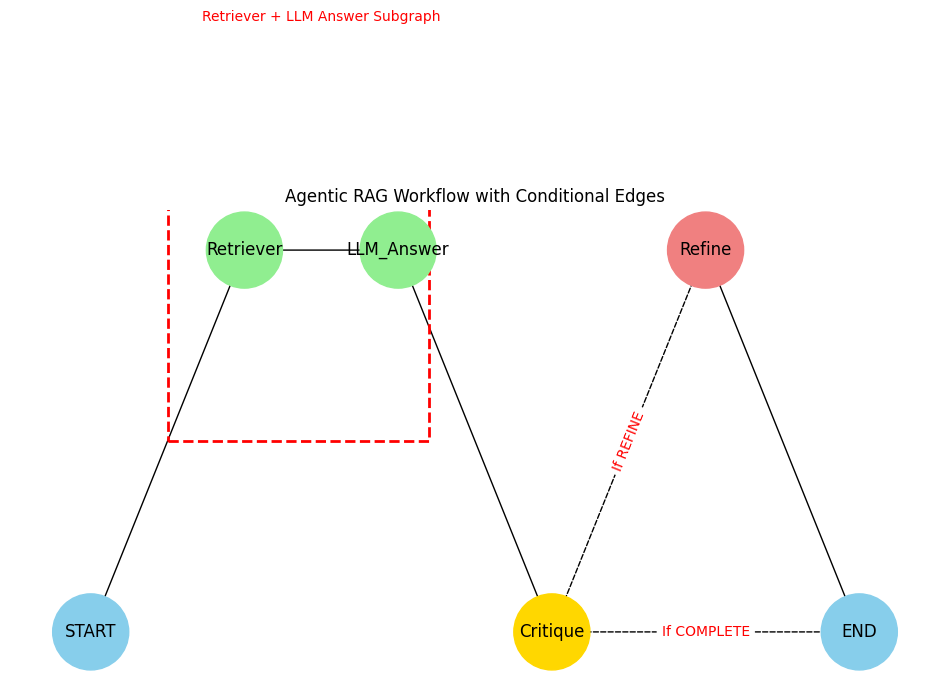

In [139]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_rag_workflow():
    """
    Visualizes the Agentic RAG Workflow:
    - Retriever + LLM Answer nodes as a subgraph
    - Critique node with conditional edges:
        • REFINE → Refine
        • COMPLETE → END
    """
    G = nx.DiGraph()

    # Nodes
    nodes = ["START", "Retriever", "LLM_Answer", "Critique", "Refine", "END"]
    G.add_nodes_from(nodes)

    # Normal edges
    normal_edges = [
        ("START", "Retriever"),
        ("Retriever", "LLM_Answer"),
        ("LLM_Answer", "Critique"),
        ("Refine", "END")
    ]
    G.add_edges_from(normal_edges, style='solid')

    # Conditional edges from Critique
    G.add_edge("Critique", "Refine", style='dashed', label='If REFINE')
    G.add_edge("Critique", "END", style='dashed', label='If COMPLETE')

    # Positions for layout (manual for subgraph clarity)
    pos = {
        "START": (0, 2),
        "Retriever": (1, 3),
        "LLM_Answer": (2, 3),
        "Critique": (3, 2),
        "Refine": (4, 3),
        "END": (5, 2)
    }

    # Node colors
    node_colors = []
    for node in G.nodes:
        if node in ["Retriever", "LLM_Answer"]:
            node_colors.append("lightgreen")  # subgraph
        elif node == "Refine":
            node_colors.append("lightcoral")
        elif node == "Critique":
            node_colors.append("gold")
        else:
            node_colors.append("skyblue")

    plt.figure(figsize=(12,6))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000)
    nx.draw_networkx_labels(G, pos)

    # Draw edges
    solid_edges = [e for e in G.edges if G.edges[e].get('style','solid')=='solid']
    dashed_edges = [e for e in G.edges if G.edges[e].get('style','solid')=='dashed']
    nx.draw_networkx_edges(G, pos, edgelist=solid_edges, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_edges(G, pos, edgelist=dashed_edges, style='dashed', arrowstyle='->', arrowsize=20)

    # Edge labels
    edge_labels = {e: G.edges[e].get('label','') for e in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # Draw rectangle around Retriever + LLM Answer subgraph
    plt.gca().add_patch(plt.Rectangle(
        (0.5, 2.5), 1.7, 1, fill=False, edgecolor='red', linewidth=2, linestyle='--'
    ))
    plt.text(1.5, 3.6, "Retriever + LLM Answer Subgraph", fontsize=10, color='red', ha='center')

    plt.title("Agentic RAG Workflow with Conditional Edges")
    plt.axis('off')
    plt.show()

# Call visualization
visualize_rag_workflow()



### Step 11: Function to call the rag pipeline code for a given user query 

In [137]:
import mlflow
from datetime import datetime

def run_agentic_rag_pipeline(user_query: str, run_name: str = None):
    """
    Runs the complete Agentic RAG workflow for a given user query.
    
    Steps:
    1. Retrieve top-5 snippets from Pinecone
    2. Generate initial answer with Azure LLM
    3. Critique completeness using LLM
    4. If incomplete, refine query and regenerate answer
    5. Log all results to MLflow (retrieval, answers, critique, final)
    """

    # Use timestamp as run_name if not provided
    run_name = run_name or f"rag_run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    print(f"\n🚀 Starting RAG Pipeline: {run_name}")
    print(f"User Query: {user_query}\n")

    # Initialize state
    state = RAGState(query=user_query)

    # Ensure MLflow tracking is set
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment("agentic_rag_pipeline")

    try:
        with mlflow.start_run(run_name=run_name):

            # Step 1: Retrieval
            state = retriever_node(state)
            mlflow.log_text(str(state.retrieved_snippets), "retrieved_snippets.txt")

            # Step 2: Initial LLM Answer
            state = llm_answer_node(state)
            mlflow.log_text(state.initial_answer, "initial_answer.txt")

            # Step 3: Critique Step
            state = critique_node(state)
            mlflow.log_param("critique_complete", state.critique_complete)

            # Step 4: Refinement (if needed)
            if not state.critique_complete:
                print("\n🔁 Refinement triggered...\n")
                state = refinement_node(state)
                mlflow.log_text(state.refined_answer, "refined_answer.txt")

            # Step 5: Final Answer Decision
            state.final_answer = (
                state.initial_answer if state.critique_complete else state.refined_answer
            )
            mlflow.log_text(state.final_answer, "final_answer.txt")

            print("\n=== ✅ FINAL ANSWER ===")
            print(state.final_answer)
            print("\n--- Workflow Complete ---\n")

            # Log metadata
            mlflow.log_param("query", user_query)
            mlflow.log_param("retrieved_docs", len(state.retrieved_snippets))
            mlflow.log_param("final_decision", "COMPLETE" if state.critique_complete else "REFINE")

            # Return state for further inspection if needed
            return state

    except Exception as e:
        print(f"❌ Pipeline error: {e}")
        mlflow.log_param("error", str(e))
        raise


In [140]:
user_query = "What is caching?"
run_agentic_rag_pipeline(user_query=user_query)


🚀 Starting RAG Pipeline: rag_run_20251005_125117
User Query: What is caching?


=== NODE: Retriever ===


2025-10-05 12:51:18,571 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Retrieved Snippets:
1. [KB003] (Score: 0.6008) When addressing caching, it's important to follow well-defined patterns......
2. [KB012] (Score: 0.2522) When addressing performance tuning, it's important to follow well-defined patterns......
Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB003', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB012', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-06-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': '', 'critique_complete': False, 'refined_query': '', 'refined_ans

2025-10-05 12:51:21,486 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 LLM Answer (using snippet as ground truth):
When addressing caching, it's important to follow well-defined patterns... [KB003]
Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB003', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB012', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-06-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': "When addressing caching, it's important to follow well-defined patterns... [KB003]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}

2025-10-05 12:51:22,013 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB003', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB012', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-06-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], 'initial_answer': "When addressing caching, it's important to follow well-defined patterns... [KB003]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}
Critique result: REFINE

🔁 Refinement triggered...


=== NODE: Refinement ===


2025-10-05 12:51:22,711 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Refined Query: What are the different types of caching, and how do they work? Additionally, can you explain the benefits and use cases of caching in computing?


2025-10-05 12:51:23,020 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


⚠️ No new snippet found for refinement.


2025-10-05 12:51:24,965 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 Refined Answer:
There are several types of caching, including memory caching, disk caching, and distributed caching. Caching improves performance by storing frequently accessed data for quick retrieval, reducing latency and load on the underlying data source. Common use cases include web applications, databases, and content delivery networks. For more on caching patterns, see [KB003].
Current State: {'query': 'What is caching?', 'retrieved_snippets': [{'id': 'KB003', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB012', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-06-10', 'question': 'What are best practices for

RAGState(query='What is caching?', retrieved_snippets=[{'id': 'KB003', 'score': 0.600841522, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB012', 'score': 0.252180099, 'metadata': {'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-06-10', 'question': 'What are best practices for performance tuning?', 'source': 'performance tuning_guide.md'}}], initial_answer="When addressing caching, it's important to follow well-defined patterns... [KB003]", critique_complete=False, refined_query='What are the different types of caching, and how do they work? Additionally, can you explain the benefits and use cases of caching in computing?', refined_answer='There are several types of cachin

In [141]:
user_query = "Best practices for CICD?"
run_agentic_rag_pipeline(user_query=user_query)


🚀 Starting RAG Pipeline: rag_run_20251005_125202
User Query: Best practices for CICD?


=== NODE: Retriever ===


2025-10-05 12:52:03,118 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Retrieved Snippets:
1. [KB017] (Score: 0.6925) When addressing CI/CD, it's important to follow well-defined patterns......
2. [KB013] (Score: 0.4275) When addressing caching, it's important to follow well-defined patterns......
Current State: {'query': 'Best practices for CICD?', 'retrieved_snippets': [{'id': 'KB017', 'score': 0.692518175, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}, {'id': 'KB013', 'score': 0.427465439, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-01-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}], 'initial_answer': '', 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}

=== NODE: LLM

2025-10-05 12:52:04,975 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 LLM Answer (using snippet as ground truth):
When addressing CI/CD, it's important to follow well-defined patterns... [KB017]
Current State: {'query': 'Best practices for CICD?', 'retrieved_snippets': [{'id': 'KB017', 'score': 0.692518175, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}, {'id': 'KB013', 'score': 0.427465439, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-01-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}], 'initial_answer': "When addressing CI/CD, it's important to follow well-defined patterns... [KB017]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}

=== NODE: Critique ===


2025-10-05 12:52:05,477 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Current State: {'query': 'Best practices for CICD?', 'retrieved_snippets': [{'id': 'KB017', 'score': 0.692518175, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}, {'id': 'KB013', 'score': 0.427465439, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-01-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}], 'initial_answer': "When addressing CI/CD, it's important to follow well-defined patterns... [KB017]", 'critique_complete': False, 'refined_query': '', 'refined_answer': '', 'final_answer': ''}
Critique result: REFINE

🔁 Refinement triggered...


=== NODE: Refinement ===


2025-10-05 12:52:06,401 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Refined Query: What are the specific best practices for implementing CI/CD pipelines, including tools, methodologies, and common pitfalls to avoid? Additionally, can you provide examples of successful CI/CD implementations?


2025-10-05 12:52:06,678 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/text-embedding-3-small/embeddings?api-version=2024-08-01-preview "HTTP/1.1 200 OK"


Added extra snippet for refinement: KB027


2025-10-05 12:52:11,255 | INFO | HTTP Request: POST https://eastus.api.cognitive.microsoft.com/openai/deployments/gpt4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"



🧩 Refined Answer:
To implement effective CI/CD pipelines, follow well-defined patterns, utilize tools like Jenkins, GitLab CI, or CircleCI, and adopt methodologies such as version control and automated testing. Common pitfalls include neglecting security and failing to monitor performance. For successful implementations, consider companies like Netflix and Amazon, which have robust CI/CD practices. [KB017][KB027]
Current State: {'query': 'Best practices for CICD?', 'retrieved_snippets': [{'id': 'KB017', 'score': 0.692518175, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}, {'id': 'KB013', 'score': 0.427465439, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-01-10', 'question': 'What are 

RAGState(query='Best practices for CICD?', retrieved_snippets=[{'id': 'KB017', 'score': 0.692518175, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-05-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}, {'id': 'KB013', 'score': 0.427465439, 'metadata': {'answer_snippet': "When addressing caching, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-01-10', 'question': 'What are best practices for caching?', 'source': 'caching_guide.md'}}, {'id': 'KB027', 'score': 0.71712774, 'metadata': {'answer_snippet': "When addressing CI/CD, it's important to follow well-defined patterns...", 'confidence': 'moderate', 'last_updated': '2024-03-10', 'question': 'What are best practices for CI/CD?', 'source': 'CI/CD_guide.md'}}], initial_answer="When addressing CI/CD, it's important to follow well-defined patterns...

---

## 🧭 Notebook Summary

This notebook demonstrates the complete implementation of an **Agentic RAG System** using **Azure OpenAI**, **Pinecone**, **LangGraph**, and **MLflow**.

### ✅ Covered Components

| # | Component | Description |
|---|------------|-------------|
| 1️⃣ | **Knowledge Base Indexing** | Loads and embeds KB JSON entries using Azure Embeddings and indexes them into Pinecone. |
| 2️⃣ | **Retrieval & Deduplication** | Retrieves top-K semantically similar snippets from the KB, ensuring distinct results. |
| 3️⃣ | **LLM Answer Generation** | Uses Azure GPT-4 (temperature = 0) to generate concise, citation-based answers from retrieved KB snippets. |
| 4️⃣ | **Self-Critique Logic** | LLM-based evaluation step that judges whether the generated answer is **COMPLETE** or needs **REFINEMENT**. |
| 5️⃣ | **Query & Answer Refinement** | If incomplete, refines the query using the LLM, retrieves one additional snippet, and regenerates a shorter answer. |
| 6️⃣ | **Conditional Workflow Compilation** | LangGraph pipeline connects Retriever → LLM → Critique → (Refine if needed) → END using conditional edges. |
| 7️⃣ | **MLflow Logging & Observability** | Logs retrieved snippets, generated answers, critique flags, and final outputs for full experiment tracking. |
| 8️⃣ | **Visualization** | Displays workflow structure both as a **graph** and as a **mermaid flowchart**, including subgraphs for retrieval and LLM nodes. |

---

### 🧩 Key Highlights

- Modular design — each node is independently callable and testable.  
- Automatic observability — all outputs logged in MLflow.  
- Agentic control flow — dynamic refinement based on self-critique.  
- Extensible — supports swapping Pinecone with Weaviate or Azure Cognitive Search.  
- Ready for production — deterministic LLM behavior (`temperature=0`).

---

**End of Notebook ✅**

---


### Thank You!